# Import Libraries

This part of code will import all the necessary libraries required for the code

In [1]:
from pyDTDM import *
import warnings
import yaml
try:
    from yaml import Cloader as Loader
except ImportError:
    from yaml import Loader


import pandas as pd
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import os, sys
import cartopy.crs as ccrs
import warnings
from sklearn.model_selection import train_test_split

import numpy as np


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


# Load Input File

The input file can be changed to include other parameters as well

In [2]:
config_file="InputFiles/InputFiles.yaml"
with open(config_file) as f:
    PARAMS = yaml.load(f, Loader=Loader)
print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")
print(" Parameters set from %s" % config_file)
print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")


––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 
 Parameters set from InputFiles/InputFiles.yaml
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 


### Reading the input file

In [3]:
# Input Files 
MODEL_NAME=PARAMS['InputFiles']['plate_kinematics']['model_name'] # model name
MODEL_DIR = PARAMS['InputFiles']['plate_kinematics']['model_dir']  ## plate model location
topology_filenames =[f"{MODEL_DIR}/{i}" for i in PARAMS['InputFiles']['plate_kinematics']['topology_files']]
rotation_filenames = [f"{MODEL_DIR}/{i}" for i in PARAMS['InputFiles']['plate_kinematics']['rotation_files']]
agegrid=PARAMS['InputFiles']['plate_kinematics']['agegrid'] ## agegrid location

ETOPO_FILE=PARAMS['InputFiles']['Raster']['ETOPO_FILE'] # ETOPO grid in meters (can be netCDf or GeoTiff)
ETOPO_Type=PARAMS['InputFiles']['Raster']['Raster_type']
coastlines = f"{MODEL_DIR }/{PARAMS['InputFiles']['plate_kinematics']['coastline_file']}"
static_polygon_file=f"{MODEL_DIR }/{PARAMS['InputFiles']['plate_kinematics']['static_polygon']}"
static_polygons = pygplates.FeatureCollection(static_polygon_file)
continents=f"{MODEL_DIR }/{PARAMS['InputFiles']['plate_kinematics']['continents']}"
print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")
print("Reading input file..... \n")
print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")
print(f"Plate Model: {MODEL_NAME} \n")
print(f"Model Directory: {MODEL_DIR} \n")
print(f"Coastlines: {coastlines} \n")
print(f"Continents: {continents} \n")
print(f"Static Polygons: {static_polygon_file} \n")
print(f"Model Agegrid: {agegrid} \n")
print(f"ETopo grid: {ETOPO_FILE}")
print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– \n")

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 
Reading input file..... 

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 
Plate Model: Zahirovic_etal_2022_GDJ_NNR 

Model Directory: ../../../PlateReconstruction 

Coastlines: ../../../PlateReconstruction/StaticGeometries/Coastlines/Global_coastlines_low_res.shp 

Continents: ../../../PlateReconstruction/StaticGeometries/ContinentalPolygons/Global_EarthByte_GPlates_PresentDay_ContinentalPolygons.shp 

Static Polygons: ../../../PlateReconstruction/StaticGeometries/StaticPolygons/Global_EarthByte_GPlates_PresentDay_StaticPlatePolygons.shp 

Model Agegrid: ../../../PlateReconstruction/SeafloorAgegrid 

ETopo grid: ../../../ETOPO/Smoothed Etopo.tif
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 



### Setting model parameters

In [4]:
Mantle_ID=PARAMS['Parameters']['mantle_optimised_id']

#The initial positions of crustal points are evenly distributed within the designated region. 
# At mesh refinement level zero, the points are approximately 20 degrees apart.
# Each increase in the density level results in a halving of the spacing between points.
MESH_REFINEMENT_LEVEL=PARAMS['Parameters']['mesh_refinement_level']  # higher refinement level will take longer time to run for optimisation 
WINDOW_SIZE=int(PARAMS['Parameters']['time_window_size'])
Weighted=PARAMS['Parameters']['weighted_mean']


NETCDF_GRID_RESOLUTION=PARAMS['GridParameters']['grid_spacing']  # in degree
ZLIB=PARAMS['GridParameters']['compression']['zlib'] 
COMPLEVEL=PARAMS['GridParameters']['compression']['complevel'] 

FROM_TIME=int(PARAMS['TimeParameters']['time_max'])
TO_TIME=int(PARAMS['TimeParameters']['time_min'])
TIME_STEPS=int(PARAMS['TimeParameters']['time_step'])




parallel=PARAMS['Parameters']['number_of_cpus']### No of core to use or None for single core


print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")
print("The following parameters are set-")
print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")
print(f"NNR Mantle Reference Frame ID: {Mantle_ID}")


print(f"Moving Window Size: {WINDOW_SIZE}")
print(f"Weighted Mean: {Weighted}")

print(f"Mesh Refinement Level: {MESH_REFINEMENT_LEVEL}")
print(f"NetCDF GRID Resolution: {NETCDF_GRID_RESOLUTION}")
print(f"NetCDF Compression Level: {COMPLEVEL} \n")
print(f"Model Start Time: {FROM_TIME}")
print(f"Model End Time: {TO_TIME}")
print(f"Model Time Step: {TIME_STEPS}\n")


print(f"Number of CPU: {parallel}") # -1 means all the freely available CPU


print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 
The following parameters are set-
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 
NNR Mantle Reference Frame ID: 666666
Moving Window Size: 15
Weighted Mean: True
Mesh Refinement Level: 9
NetCDF GRID Resolution: 0.1
NetCDF Compression Level: 5 

Model Start Time: 125
Model End Time: 0
Model Time Step: 1

Number of CPU: -1
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 


### Creating Output File

The output will be stored in the output folder: Paleotopography

There will be two folder:
- CSV Folder: to store data in tabular format. Here I have used paraquet file because it reduces the storage 
- NetCDF Folder: to store final NetCDF that can be visualised in GPlates


In [5]:
# Output Directory
OUTPUT_FOLDER=PARAMS['OutputFiles']['output_dir']

DEFAULT_OUTPUT_CSV=os.path.join(OUTPUT_FOLDER,'CSV')  # folder to store output in Tabular format
DEFAULT_OUTPUT_Figure=os.path.join(OUTPUT_FOLDER,'Figure')




print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")
print(f"All the output will be saved in {OUTPUT_FOLDER}")
print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")
create_directory_if_not_exists(OUTPUT_FOLDER)
create_directory_if_not_exists(DEFAULT_OUTPUT_CSV)
create_directory_if_not_exists(DEFAULT_OUTPUT_Figure)
print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")


––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 
All the output will be saved in ../../../EBM_Results
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 


# Define Plate Reconstruction

class PlateKinematicsParameters can be used to define plate kinematics parameters. To know more about class you can use `help` functions. For e.g. help(PlateKinematicsParameters) 

In [6]:

PK=PlateKinematicsParameters(topology_filenames, 
                             rotation_filenames,
                             static_polygons,
                             agegrid=agegrid,
                             coastlines=coastlines,
                             continents=continents,
                             anchor_plate_id=Mantle_ID)

time = 0 #Ma
gplot = gplately.PlotTopologies(PK.model, coastlines=coastlines, continents=continents, time=time) ##gplately plotting object


#### Read the all the subduction stats

In [7]:
all_sz_df=pd.read_parquet(f"{DEFAULT_OUTPUT_CSV}/ALL_Subduction.paraquet") 

## Load Training Data

In [8]:

filtered_df=gpd.read_file(f"{DEFAULT_OUTPUT_CSV}/Filtered_GMBA_Hier_Lvl3.shp")
## In case you want to remove any mountain
# List of mountain ranges to filter out
mountain_ranges_to_exclude = [
    "Atlas Mountains",
    "Zagros Mountains",
    "Baetic System",
    "Pyrenees"
]

# mountains_to_remove=["Atlas Mountains"]
filtered_df = filtered_df[~filtered_df['MapName'].isin(mountain_ranges_to_exclude)]
print(f"Number of Mountains: {len(filtered_df)}")
Arcs=filtered_df.copy()

Number of Mountains: 48


In [9]:
# Location for output
unprocessed_training_data=f"{DEFAULT_OUTPUT_CSV}/Training_Data_Unprocessed"
processed_training_data=f"{DEFAULT_OUTPUT_CSV}/Training_Data_Processed"
create_directory_if_not_exists(processed_training_data)

# Getting Mean Parameters and Testing Window Size

In [10]:
def mean_subduction_params(
    training_data_folder, 
    starttime, 
    endtime, 
    mean_columns=None,       # columns to perform cumulative averaging
    humid_belt=False, 
    lat_band=10
):
    """
    Compute cumulative (or mean) subduction parameters over a time range.

    Parameters
    ----------
    training_data_folder : str
        Folder containing per-time parquet files named `Training_Data_<t>.csv`.
    starttime : int
        Start time (inclusive).
    endtime : int
        End time (exclusive).
    mean_columns : list of str
        Columns to perform cumulative mean on. If None, all numeric columns (except ignored ones) are used.
    humid_belt : bool
        Whether to add a 'Humid Belt' column based on latitude.
    lat_band : int
        Latitude band size for humid belt assignment.

    Returns
    -------
    cumulative : pandas.DataFrame
        Cumulative DataFrame over the time range.
    """
    
    times = np.arange(starttime, endtime)
    
    # Load the first timestep
    df = pd.read_parquet(f"{training_data_folder}/Training_Data_{times[0]}.csv")
    
    # Automatically determine columns to process if not provided
    ignore_cols = ['Latitude', 'Longitude', 'geometry']
    if mean_columns is None:
        mean_columns = [col for col in df.columns if col not in ignore_cols]
    
    # Initialize cumulative DataFrame
    cumulative = df.copy()
    cumulative[mean_columns] = cumulative[mean_columns] / (endtime - starttime)
    
    # Optionally, add Humid Belt column
    if humid_belt:
        cumulative['Humid Belt'] = df['Latitude'].apply(lambda x: assign_belt(x, lat_band))
    
    # Loop over remaining times
    for t in times[1:]:
        df = pd.read_parquet(f"{training_data_folder}/Training_Data_{t}.csv")
        
        # Update cumulative columns
        cumulative[mean_columns] += df[mean_columns] / (endtime - starttime)
        
        if humid_belt:
            cumulative['Humid Belt'] += df['Latitude'].apply(lambda x: assign_belt(x, lat_band))
    
    return cumulative

In [12]:
processed_training_data=f"{DEFAULT_OUTPUT_CSV}/Training_Data_Processed"
WINDOW_SIZES=[10,15,20,25,30,35,40,45,50,60,70,80,90,100]

mean_params=[]

for WINDOW_SIZE in WINDOW_SIZES:
    print(f"Getting mean subduction kinematics for {WINDOW_SIZE} Myr")
    mean_param=mean_subduction_params(training_data_folder=processed_training_data,
                                        starttime=0,endtime=WINDOW_SIZE)
    mean_params.append(mean_param)

    

Getting mean subduction kinematics for 10 Myr
Getting mean subduction kinematics for 15 Myr
Getting mean subduction kinematics for 20 Myr
Getting mean subduction kinematics for 25 Myr
Getting mean subduction kinematics for 30 Myr
Getting mean subduction kinematics for 35 Myr
Getting mean subduction kinematics for 40 Myr
Getting mean subduction kinematics for 45 Myr
Getting mean subduction kinematics for 50 Myr
Getting mean subduction kinematics for 60 Myr
Getting mean subduction kinematics for 70 Myr
Getting mean subduction kinematics for 80 Myr
Getting mean subduction kinematics for 90 Myr
Getting mean subduction kinematics for 100 Myr


## Filtering data point based on active mountains polygons

In [13]:
filtered_df=gpd.read_file(f"{DEFAULT_OUTPUT_CSV}/Filtered_GMBA_Hier_Lvl3.shp")
filtered_df2=gpd.read_file(f"{DEFAULT_OUTPUT_CSV}/Filtered_GMBA_Hier_Lvl4.shp")
### We will filter the 10 My window data and use it elsewhere

gdf_points=gpd.GeoDataFrame(mean_params[0],geometry=latlonlist2point(mean_params[0]['Latitude'],mean_params[0]['Longitude']))
gdf_points=gdf_points.set_crs(DEFAULT_CRS)


# Explode multipolygon geometries into individual polygons
filtered_df2_exploded = filtered_df2.explode(index_parts=False)

# Ensure both GeoDataFrames have the same CRS
gdf_points = gdf_points.to_crs(DEFAULT_CRS)
filtered_df2_exploded = filtered_df2_exploded.to_crs(DEFAULT_CRS)

# Perform the spatial join using the 'intersects' predicate
filtered_data = gpd.sjoin(gdf_points, filtered_df2_exploded, how='left', predicate='intersects')

# Filter out points that do not intersect with any polygon
filtered_data = filtered_data.dropna(subset=['index_right'])

# Get the filtered gdf_points with overlapping geometries
filtered_gdf_points = gdf_points[gdf_points.index.isin(filtered_data.index)]

# Visualize the result
print(filtered_gdf_points)

# Get the indices of filtered_gdf_points
filtered_indices = filtered_gdf_points.index

# Filter each DataFrame in cumulatives to keep only rows with matching indices
filtered_means = [df.loc[filtered_indices] for df in mean_params]

filtered_means= [df.assign(**{"Migration Rate": df["Migration Rate"] * 1e2}) for df in filtered_means]
filtered_means= [df.assign(**{"Trench Distance": df["Trench Distance"] /1e3}) for df in filtered_means]

        Latitude  Longitude                   geometry  Trench Distance  \
0        32.5124    61.1509    POINT (61.1509 32.5124)    707175.359041   
1        32.6124    61.1509    POINT (61.1509 32.6124)    717105.286971   
2        32.5124    61.2509    POINT (61.2509 32.5124)    711272.038520   
3        32.6124    61.2509    POINT (61.2509 32.6124)    721268.787278   
4        32.2124    61.3509    POINT (61.3509 32.2124)    684657.663618   
...          ...        ...                        ...              ...   
145491  -10.6606   152.7506  POINT (152.7506 -10.6606)    480681.962317   
145492  -11.4606   153.4506  POINT (153.4506 -11.4606)    557069.808063   
145493  -11.3606   154.0506  POINT (154.0506 -11.3606)    529769.035454   
145494  -11.3606   154.1506  POINT (154.1506 -11.3606)    524595.358612   
145495  -11.3606   154.2506  POINT (154.2506 -11.3606)    519423.177484   

        Trench Latitude  Trench Longitude  Convergence Rate  Migration Rate  \
0             26.712

## Sample Elevation as Training Data points

In [14]:
ETopo=BhuRaster(folder_location=ETOPO_FILE,Raster_Type=ETOPO_Type)
features=ETopo.get_parameters(filtered_means[0])

## Selecting Only Plate Kinematics Columns

In this step, we will focus exclusively on the plate kinematics features to test their individual role in the analysis.


In [15]:
## select only p.k. columns for Training
columns_data=['Migration Rate',
        'Subduction Volume Rate',
        'Trench Distance','Elevation']

features_pk=features.copy()
features_pk=features_pk[columns_data]

In [16]:
filtered_means_pk = [pd.concat([df, features[['Elevation']]], axis=1) for df in filtered_means]
filtered_means_pk = [df[columns_data] for df in filtered_means_pk ]


In [17]:
filtered_means_pk [1]

,Migration Rate,Subduction Volume Rate,Trench Distance,Elevation
0,2.049141,0.027602,732.344507,829.716492
1,2.049573,0.027571,742.382852,825.992310
2,1.998728,0.027928,736.288831,960.218201
3,2.023247,0.027704,746.368651,910.482483
4,1.925657,0.028476,709.515141,676.501099
...,...,...,...,...
145491,-4.259435,0.025780,384.304348,38.126770
145492,-4.754705,0.023344,446.716795,131.765366
145493,-4.241392,0.027501,429.332046,59.374172
145494,-4.269139,0.029823,426.128210,121.880447


In [18]:
list(features_pk.columns)

['Migration Rate', 'Subduction Volume Rate', 'Trench Distance', 'Elevation']

# Building a EBM model with only Plate Kinematics

In [19]:
coltrain=['Elevation','Subduction Volume Rate','Migration Rate', 'Trench Distance']
filtered_means_pk_with_features = [
   df[coltrain]  # Ensuring correct index alignment
    for df in filtered_means_pk
]
# Drop duplicate columns in each DataFrame in the list
filtered_means_pk_no_duplicates = [
    df.loc[:, ~df.columns.duplicated()]  # Remove duplicated columns
    for df in filtered_means_pk_with_features
]

In [ ]:
rmse_tests=[]
rmse_trains=[]
k=0
for featuresc in filtered_means_pk_no_duplicates :


    X_train, X_test, y_train, y_test = train_test_split(featuresc.drop(columns=['Elevation']), featuresc['Elevation'], test_size=0.3, random_state=22)
    interactions=[(0,1),(0,2),(1,2)] ### all the pairs
    XAI=EBMModel(features,interactions=interactions)
    ebm=XAI.model
    ebm.fit(X_train, y_train.to_numpy())
    # Make predictions on the test set
    y_pred_test = ebm.predict(X_test)
    y_pred_train = ebm.predict(X_train)
    # Calculate the root mean squared error
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))

    rmse_tests.append(rmse_test)
    rmse_trains.append(rmse_train)
    print("Window Size:",WINDOW_SIZES[k],"Myr,","Root Mean Squared Error:", rmse_test, '  ', rmse_train)
    k+=1

Window Size: 10 Myr, Root Mean Squared Error: 476.7065847442821    431.3072625893094
Window Size: 15 Myr, Root Mean Squared Error: 473.44806973719324    429.4063485477103
Window Size: 20 Myr, Root Mean Squared Error: 476.44038694198116    433.7519292400237
Window Size: 25 Myr, Root Mean Squared Error: 477.79956156858555    433.67597002664553
Window Size: 30 Myr, Root Mean Squared Error: 479.3265873723051    436.49303819683547
Window Size: 35 Myr, Root Mean Squared Error: 479.3020561025789    435.9353191458266
Window Size: 40 Myr, Root Mean Squared Error: 490.38955228001566    446.23669117843235
Window Size: 45 Myr, Root Mean Squared Error: 482.9075797876519    438.5987313157223
Window Size: 50 Myr, Root Mean Squared Error: 480.8569702033727    437.7588707272418
Window Size: 60 Myr, Root Mean Squared Error: 496.841121065298    455.53467028023374
Window Size: 70 Myr, Root Mean Squared Error: 483.6451993232392    447.2358215465652
Window Size: 80 Myr, Root Mean Squared Error: 502.44021261

# Testing Paleoclimate Window Size

This section evaluates the effect of different temporal window sizes in the paleoclimate data on the model results.


In [105]:
columns_data=['Migration Rate',
        'Subduction Volume Rate',
        'Trench Distance','Precipitation','Elevation']

features_cm=features.copy()
features_cm=features_cm[columns_data]

In [106]:
filtered_means_cm = [pd.concat([df, features[['Elevation']]], axis=1) for df in filtered_means]
filtered_means_cm = [df[columns_data] for df in filtered_means_cm ]
filtered_means_cm [1]

,Migration Rate,Subduction Volume Rate,Trench Distance,Precipitation,Elevation
0,2.049141,0.027602,732.344507,1248.869719,829.716492
1,2.049573,0.027571,742.382852,1243.476793,825.992310
2,1.998728,0.027928,736.288831,1248.827427,960.218201
3,2.023247,0.027704,746.368651,1243.470421,910.482483
4,1.925657,0.028476,709.515141,1251.189189,676.501099
...,...,...,...,...,...
145491,-4.259435,0.025780,384.304348,1413.841145,38.126770
145492,-4.754705,0.023344,446.716795,1412.124224,131.765366
145493,-4.241392,0.027501,429.332046,1447.481094,59.374172
145494,-4.269139,0.029823,426.128210,1451.787275,121.880447


In [107]:
filtered_means_cm_with_features = [
   df[columns_data]  # Ensuring correct index alignment
    for df in filtered_means_cm
]
# Drop duplicate columns in each DataFrame in the list
filtered_means_cm_no_duplicates = [
    df.loc[:, ~df.columns.duplicated()]  # Remove duplicated columns
    for df in filtered_means_cm_with_features
]

In [ ]:
rmse_tests_cm=[]
rmse_trains_cm=[]
k=0
for featuresc in filtered_means_cm_no_duplicates :
    # print(featuresc)
    X_train, X_test, y_train, y_test = train_test_split(featuresc.drop(columns=['Elevation']), featuresc['Elevation'], test_size=0.3, random_state=22)
    
    interactions=[(0,1),(0,2),(1,2)] ### all the pairs
    XAI=EBMModel(features,interactions=interactions)
    ebm=XAI.model
    ebm.fit(X_train, y_train.to_numpy())
    # Make predictions on the test set
    y_pred_test = ebm.predict(X_test)
    y_pred_train = ebm.predict(X_train)
    # Calculate the root mean squared error
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))

    rmse_tests_cm.append(rmse_test)
    rmse_trains_cm.append(rmse_train)
    print("Window Size:",WINDOW_SIZES[k],"Myr,","Root Mean Squared Error:", rmse_test, '  ', rmse_train)
    k+=1

Window Size: 10 Myr, Root Mean Squared Error: 480.0947063742859    421.1435258076814
Window Size: 15 Myr, Root Mean Squared Error: 465.8653997322499    418.2833617274013


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/interpret/glassbox/_ebm/_ebm.py:869: UserWarning: Missing values detected. Our visualizations do not currently display missing values. To retain the glassbox nature of the model you need to either set the missing values to an extreme value like -1000 that will be visible on the graphs, or manually examine the missing value score in ebm.term_scores_[term_index][0]


Window Size: 20 Myr, Root Mean Squared Error: 468.4633745328197    423.21560814649024


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/interpret/glassbox/_ebm/_ebm.py:869: UserWarning: Missing values detected. Our visualizations do not currently display missing values. To retain the glassbox nature of the model you need to either set the missing values to an extreme value like -1000 that will be visible on the graphs, or manually examine the missing value score in ebm.term_scores_[term_index][0]


Window Size: 25 Myr, Root Mean Squared Error: 470.7903241786298    424.19693748414727


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/interpret/glassbox/_ebm/_ebm.py:869: UserWarning: Missing values detected. Our visualizations do not currently display missing values. To retain the glassbox nature of the model you need to either set the missing values to an extreme value like -1000 that will be visible on the graphs, or manually examine the missing value score in ebm.term_scores_[term_index][0]


Window Size: 30 Myr, Root Mean Squared Error: 477.3934415732595    431.8266497037434


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/interpret/glassbox/_ebm/_ebm.py:869: UserWarning: Missing values detected. Our visualizations do not currently display missing values. To retain the glassbox nature of the model you need to either set the missing values to an extreme value like -1000 that will be visible on the graphs, or manually examine the missing value score in ebm.term_scores_[term_index][0]


Window Size: 35 Myr, Root Mean Squared Error: 476.15620339302893    429.7513055106114


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/interpret/glassbox/_ebm/_ebm.py:869: UserWarning: Missing values detected. Our visualizations do not currently display missing values. To retain the glassbox nature of the model you need to either set the missing values to an extreme value like -1000 that will be visible on the graphs, or manually examine the missing value score in ebm.term_scores_[term_index][0]


Window Size: 40 Myr, Root Mean Squared Error: 484.10259010180334    438.92855917065503


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/interpret/glassbox/_ebm/_ebm.py:869: UserWarning: Missing values detected. Our visualizations do not currently display missing values. To retain the glassbox nature of the model you need to either set the missing values to an extreme value like -1000 that will be visible on the graphs, or manually examine the missing value score in ebm.term_scores_[term_index][0]


Window Size: 45 Myr, Root Mean Squared Error: 472.95104984994265    430.797255965787


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/interpret/glassbox/_ebm/_ebm.py:869: UserWarning: Missing values detected. Our visualizations do not currently display missing values. To retain the glassbox nature of the model you need to either set the missing values to an extreme value like -1000 that will be visible on the graphs, or manually examine the missing value score in ebm.term_scores_[term_index][0]


Window Size: 50 Myr, Root Mean Squared Error: 474.2623941219392    430.18581913357


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/interpret/glassbox/_ebm/_ebm.py:869: UserWarning: Missing values detected. Our visualizations do not currently display missing values. To retain the glassbox nature of the model you need to either set the missing values to an extreme value like -1000 that will be visible on the graphs, or manually examine the missing value score in ebm.term_scores_[term_index][0]


Window Size: 60 Myr, Root Mean Squared Error: 484.7318476581182    445.1588883314053


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/interpret/glassbox/_ebm/_ebm.py:869: UserWarning: Missing values detected. Our visualizations do not currently display missing values. To retain the glassbox nature of the model you need to either set the missing values to an extreme value like -1000 that will be visible on the graphs, or manually examine the missing value score in ebm.term_scores_[term_index][0]


Window Size: 70 Myr, Root Mean Squared Error: 472.0218675141422    435.4831562435474


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/interpret/glassbox/_ebm/_ebm.py:869: UserWarning: Missing values detected. Our visualizations do not currently display missing values. To retain the glassbox nature of the model you need to either set the missing values to an extreme value like -1000 that will be visible on the graphs, or manually examine the missing value score in ebm.term_scores_[term_index][0]


Window Size: 80 Myr, Root Mean Squared Error: 492.54031767192697    453.9381415254605


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/interpret/glassbox/_ebm/_ebm.py:869: UserWarning: Missing values detected. Our visualizations do not currently display missing values. To retain the glassbox nature of the model you need to either set the missing values to an extreme value like -1000 that will be visible on the graphs, or manually examine the missing value score in ebm.term_scores_[term_index][0]


Window Size: 90 Myr, Root Mean Squared Error: 486.6860329361426    448.88007146000325


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/interpret/glassbox/_ebm/_ebm.py:869: UserWarning: Missing values detected. Our visualizations do not currently display missing values. To retain the glassbox nature of the model you need to either set the missing values to an extreme value like -1000 that will be visible on the graphs, or manually examine the missing value score in ebm.term_scores_[term_index][0]


Window Size: 100 Myr, Root Mean Squared Error: 491.85222335492335    449.5713216482293


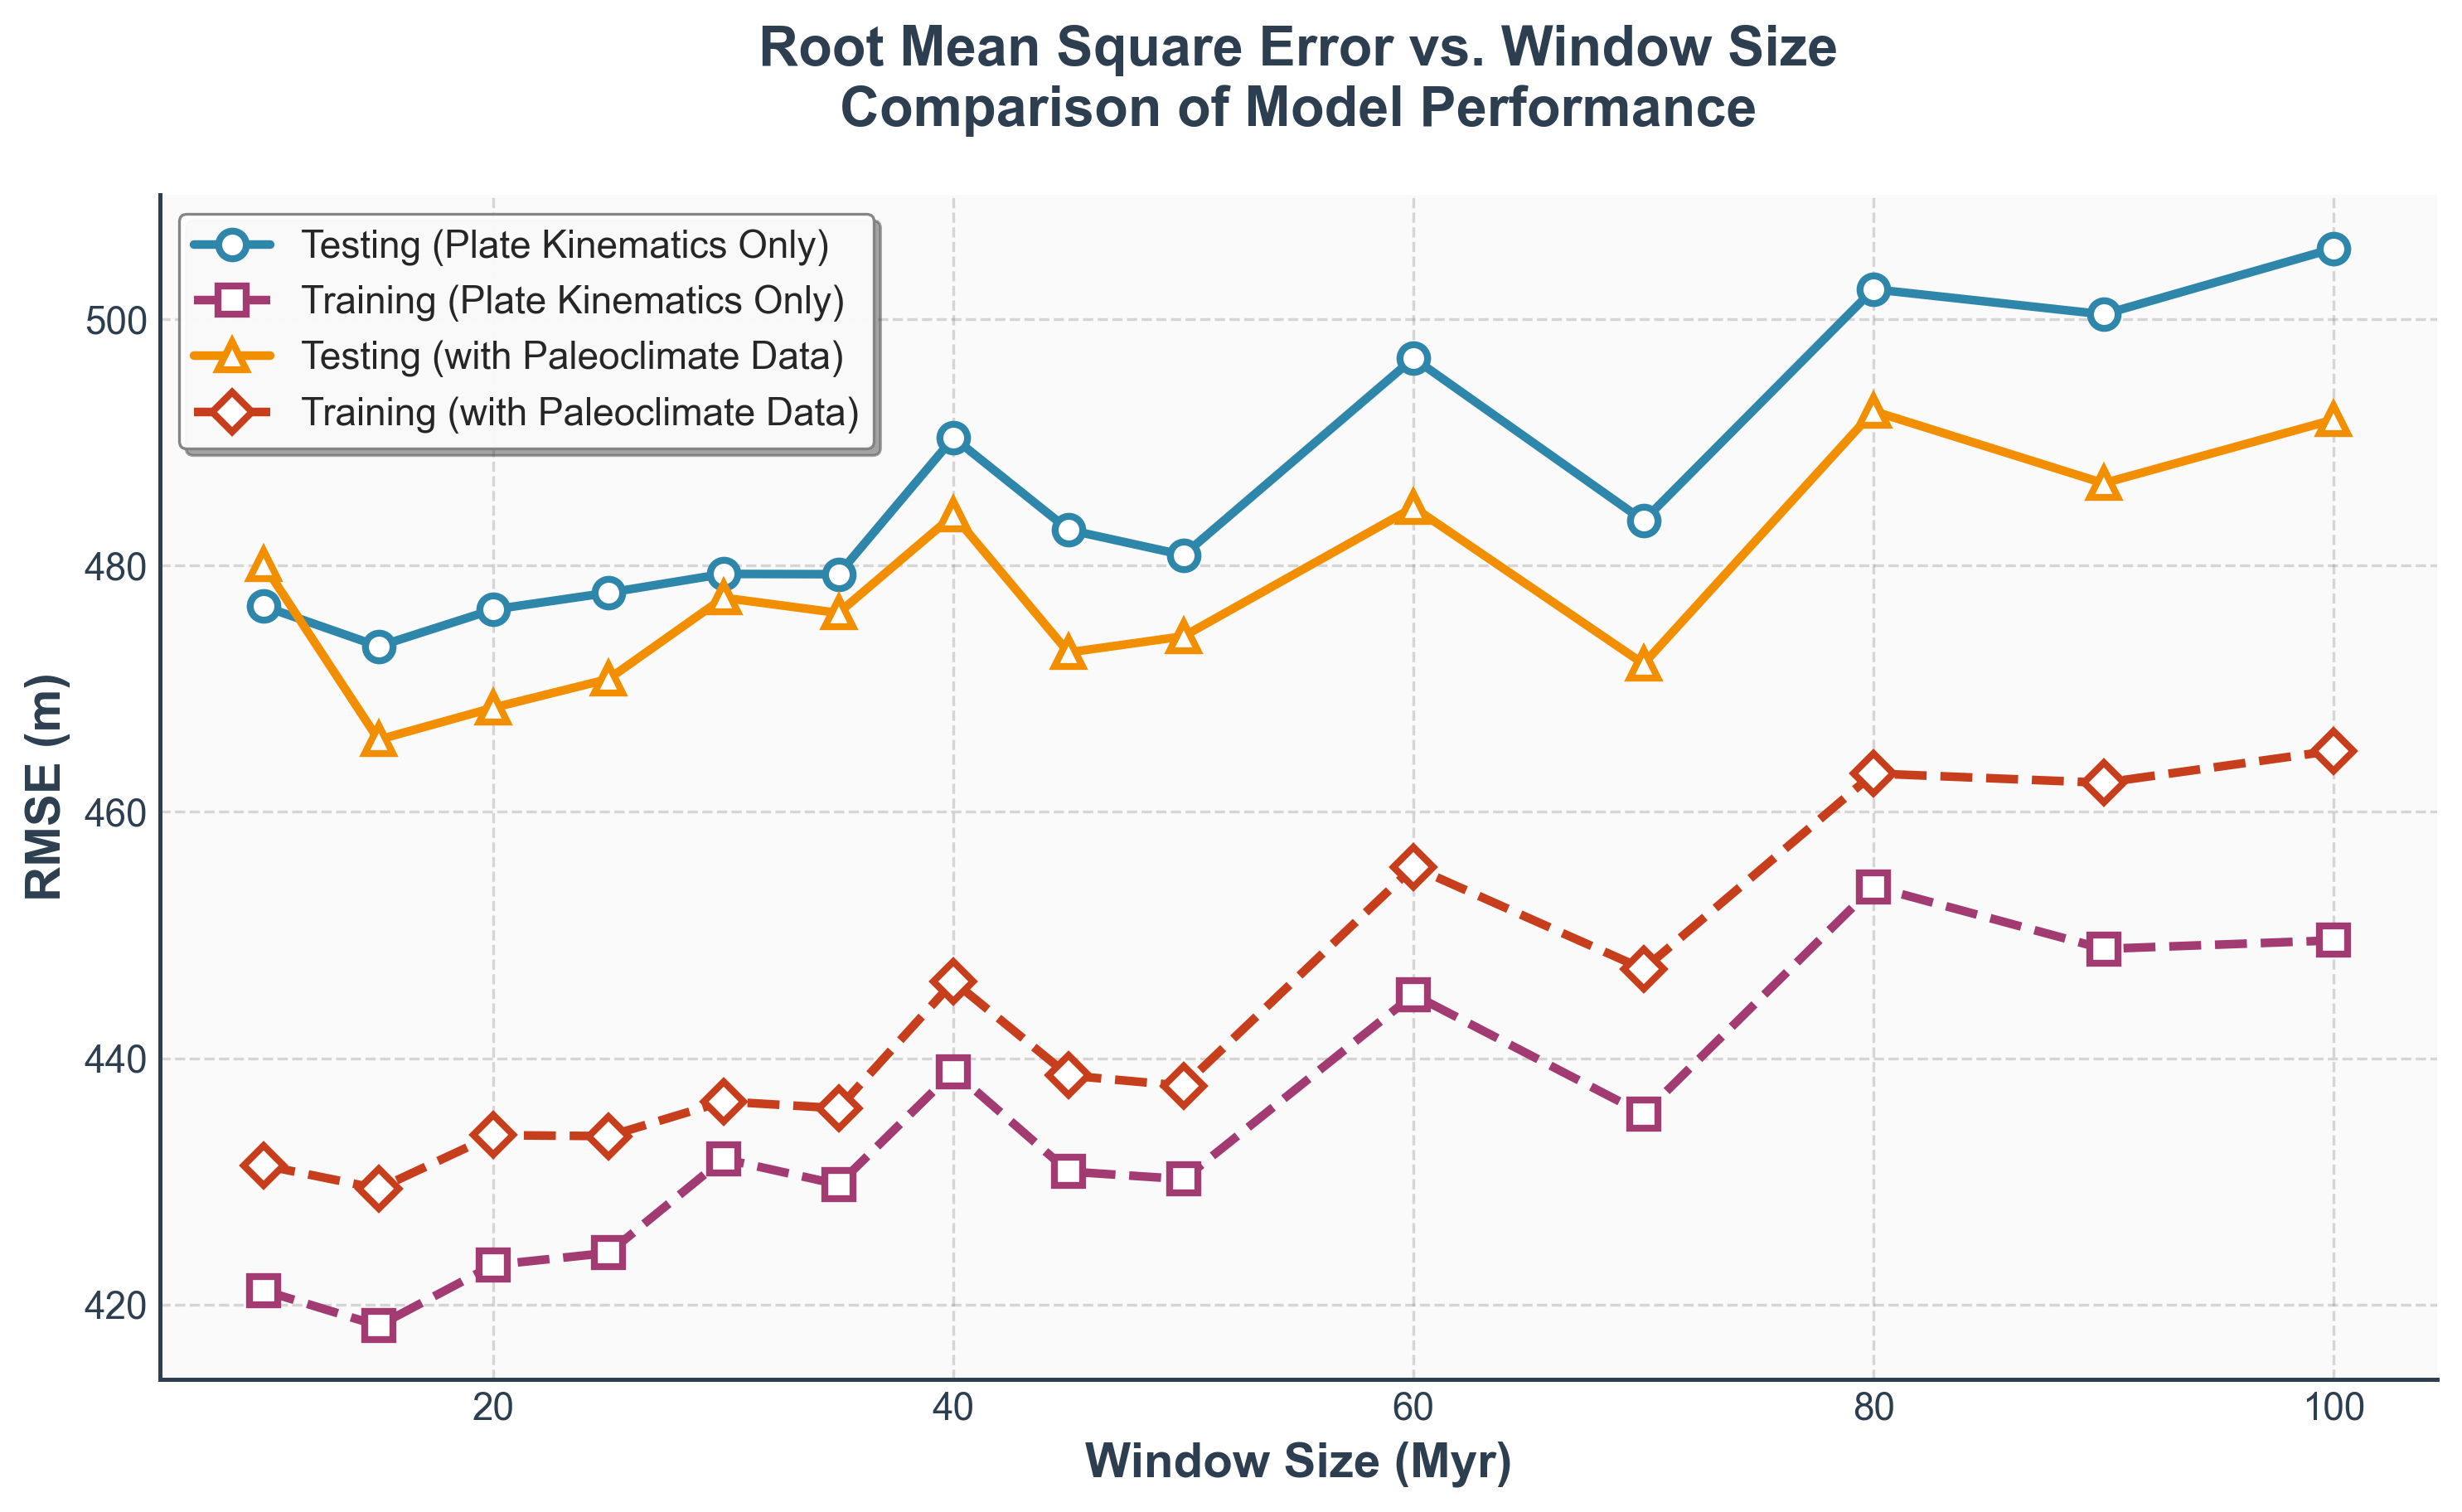

In [ ]:

# Set publication-quality style
plt.style.use('seaborn-v0_8-whitegrid')  # Clean, professional look
# Alternative: plt.style.use('default') if seaborn style not available

# Create figure with golden ratio dimensions for publication
fig, ax = plt.subplots(figsize=(10, 6.18), dpi=300)  # Golden ratio: 1.618

k = 0

# Define a professional color palette
colors = {
    'pk_test': '#2E86AB',      # Professional blue
    'pk_train': '#A23B72',     # Deep rose
    'climate_test': '#F18F01', # Warm orange
    'climate_train': '#C73E1D' # Deep red
}

# Plot with improved styling
line_width = 2.5
marker_size = 8
alpha_fill = 0.15

# Plot Only Plate Kinematics
ax.plot(WINDOW_SIZES, rmse_tests, 
        label='Testing (Plate Kinematics Only)', 
        color=colors['pk_test'], 
        linestyle='-', 
        marker='o', 
        markersize=marker_size,
        linewidth=line_width,
        markerfacecolor='white',
        markeredgewidth=2,
        markeredgecolor=colors['pk_test'])

ax.plot(WINDOW_SIZES, rmse_trains_cm, 
        label='Training (Plate Kinematics Only)', 
        color=colors['pk_train'], 
        linestyle='--', 
        marker='s', 
        markersize=marker_size,
        linewidth=line_width,
        markerfacecolor='white',
        markeredgewidth=2,
        markeredgecolor=colors['pk_train'])

# Plot with Climate data
ax.plot(WINDOW_SIZES, rmse_tests_cm, 
        label='Testing (with Paleoclimate Data)', 
        color=colors['climate_test'], 
        linestyle='-', 
        marker='^', 
        markersize=marker_size,
        linewidth=line_width,
        markerfacecolor='white',
        markeredgewidth=2,
        markeredgecolor=colors['climate_test'])

ax.plot(WINDOW_SIZES, rmse_trains, 
        label='Training (with Paleoclimate Data)', 
        color=colors['climate_train'], 
        linestyle='--', 
        marker='D', 
        markersize=marker_size,
        linewidth=line_width,
        markerfacecolor='white',
        markeredgewidth=2,
        markeredgecolor=colors['climate_train'])

# Optional: Add confidence intervals or error bands if you have error data
# ax.fill_between(WINDOW_SIZES[k:], lower_bound, upper_bound, alpha=alpha_fill, color=colors['pk_test'])

# Enhanced title and labels with better typography
ax.set_title('Root Mean Square Error vs. Window Size\nComparison of Model Performance', 
            fontsize=16, 
            fontweight='bold', 
            pad=20,
            color='#2C3E50')

ax.set_xlabel('Window Size (Myr)', fontsize=14, fontweight='semibold', color='#2C3E50')
ax.set_ylabel('RMSE (m)', fontsize=14, fontweight='semibold', color='#2C3E50')

# Improve grid appearance
ax.grid(True, linestyle='--', alpha=0.3, color='gray', linewidth=0.8)
ax.set_axisbelow(True)  # Put grid behind data

# Enhanced legend with better positioning
legend = ax.legend(loc='upper left', 
                  fontsize=11,
                  frameon=True,
                  fancybox=True,
                  shadow=True,
                  framealpha=0.95,
                  edgecolor='gray',
                  facecolor='white')

# Style the legend frame
legend.get_frame().set_linewidth(0.8)

# Improve axis appearance
ax.tick_params(axis='both', which='major', labelsize=11, colors='#2C3E50')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#2C3E50')
ax.spines['bottom'].set_color('#2C3E50')
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

# Set background color
fig.patch.set_facecolor('white')
ax.set_facecolor('#FAFAFA')

# Optimize layout
plt.tight_layout()

# Save with high quality settings
plt.savefig(f"{OUTPUT_FOLDER}/Figure/WS_PlateKinematics.png", 
           dpi=300, 
           bbox_inches='tight',
           facecolor='white',
           edgecolor='none',
           format='png',
           pad_inches=0.1)


plt.show()